## Blending
Blending is an ensemble machine learning algorithm.

It is a colloquial name for stacked generalization or stacking ensemble where instead of fitting the meta-model on out-of-fold predictions made by the base model, it is fit on predictions made on a holdout dataset.

Blending was used to describe stacking models that combined many hundreds of predictive models by competitors in the $1M Netflix machine learning competition, and as such, remains a popular technique and name for stacking in competitive machine learning circles, such as the Kaggle community.

In this tutorial, you will discover how to develop and evaluate a blending ensemble in python.

After completing this tutorial, you will know:

    Blending ensembles are a type of stacking where the meta-model is fit using predictions on a holdout validation dataset instead of out-of-fold predictions.
    How to develop a blending ensemble, including functions for training the model and making predictions on new data.
    How to evaluate blending ensembles for classification and regression predictive modeling problems.

**Blending Ensemble**

Blending is an ensemble machine learning technique that uses a machine learning model to learn how to best combine the predictions from multiple contributing ensemble member models.

As such, blending is the same as stacked generalization, known as stacking, broadly conceived. Often, blending and stacking are used interchangeably in the same paper or model description.

    Many machine learning practitioners have had success using stacking and related techniques to boost prediction accuracy beyond the level obtained by any of the individual models. In some contexts, stacking is also referred to as blending, and we will use the terms interchangeably here.

    
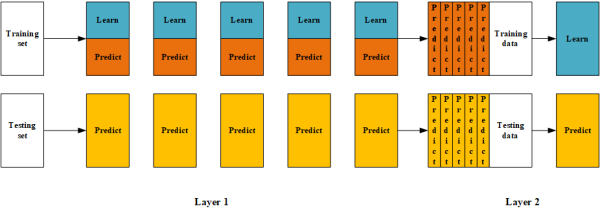

In [ ]:
#Load the librarys
import pandas as pd #To work with dataset
import numpy as np #Math library
import matplotlib.gridspec as gridspec
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn
import warnings
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
# Import StandardScaler from scikit-learn
from sklearn.preprocessing import PowerTransformer, StandardScaler,Normalizer,RobustScaler,MaxAbsScaler,MinMaxScaler,QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
# Import train_test_split()
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from datetime import datetime, date
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.model_selection import cross_val_score
import lightgbm as lgbm
from catboost import CatBoostRegressor
import  tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
#import smogn
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
# For training random forest model
import lightgbm as lgb
from scipy import sparse
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression,f_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import PolynomialFeatures
from itertools import combinations
#import smong 
from sklearn.linear_model import LinearRegression, RidgeCV
import category_encoders as ce
import warnings
import optuna 
warnings.filterwarnings('ignore')

Best pipe from last notebook : 




## Step 2: Load the data

Next, we'll load the training and test data.

We set index_col=0 in the code cell below to use the id column to index the DataFrame. (If you're not sure how this works, try temporarily removing index_col=0 and see how it changes the result.)


In [ ]:
# import lux
# Load the training data
train = pd.read_csv("../input/30-days-of-ml/train.csv")
test = pd.read_csv("../input/30-days-of-ml/test.csv")
# Preview the data
train.head()

### Num/Cat Features 

In [ ]:
cat_columns = train.drop(['id','target'], axis=1).select_dtypes(exclude=['int64','float64']).columns
num_columns = train.drop(['id','target'], axis=1).select_dtypes(include=['int64','float64']).columns

In [ ]:
train[train.select_dtypes(['float64']).columns] = train[train.select_dtypes(['float64']).columns].apply(pd.to_numeric)
train[train.select_dtypes(['object']).columns] = train.select_dtypes(['object']).apply(lambda x: x.astype('category'))

## Define the model features and target
### Extract X and y 

In [ ]:
# Create arrays for the features and the response variable
y = train['target']
X = train.drop(['id','target'], axis=1)

## Create test and train groups

Now we’ve got our dataframe ready we can split it up into the train and test datasets for our model to use. We’ll use the Scikit-Learn train_test_split() function for this. By passing in the X dataframe of raw features, the y series containing the target, and the size of the test group (i.e. 0.1 for 10%), we get back the X_train, X_test, y_train and y_test data to use in the model.

##  What should we do for each colmun
### Separate features by dtype

Next we’ll separate the features in the dataframe by their datatype. There are a few different ways to achieve this. I’ve used the select_dtypes() function to obtain specific data types by passing in np.number to obtain the numeric data and exclude=['np.number'] to return the categorical data. Appending .columns to the end returns an Index list containing the column names. For the categorical features, we don’t want to include the target income column, so I’ve dropped that.
### Cat Features 

In [ ]:
# select non-numeric columns
cat_columns = train.drop(['id','target'], axis=1).select_dtypes(exclude=['int64','float64']).columns

### Num Features 

In [ ]:
# select the float columns
num_columns = train.drop(['id','target'], axis=1).select_dtypes(include=['int64','float64']).columns

In [ ]:
num_columns=['cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7',
       'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13']
cat_columns=['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9']
all_columns = (num_columns+cat_columns)
print(cat_columns)
print(num_columns)
print(all_columns)

## check that we have all column

In [ ]:
if set(all_columns) == set(train.drop(['id','target'], axis=1).columns):
    print('Ok')
else:
    # Let's see the difference 
    print('dans all_columns mais pas dans train  :', set(all_columns) - set(train.drop(['id','target'], axis=1).columns))
    print('dans X.columns   mais pas dans all_columns :', set(train.drop(['id','target'], axis=1).columns) - set(all_columns))

## Compelete prerocess pipe for  Cat dara 

In [ ]:
cross_validation_design = KFold(n_splits=7,
                                shuffle=True,
                                random_state=77)

cross_validation_design

In [ ]:
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression,f_classif
from sklearn.preprocessing import PolynomialFeatures




###################
Robustscaler  = make_pipeline( SimpleImputer(strategy='median',add_indicator=True),
                      
                        RobustScaler()
)
Ordinalencoder = make_pipeline(
            SimpleImputer(strategy='most_frequent',add_indicator=True),
            ce.ordinal.OrdinalEncoder() )
# Preprocess Pipe : 
##################
OrdinalEncoder_RobustScaler = make_column_transformer(
    ( Ordinalencoder , cat_columns),
    ( Robustscaler, num_columns))


# Random HyperParameters
###################

xgb_params = {
    #'tree_method':'gpu_hist',         ## parameters for gpu
    #'gpu_id':0,                       #
    #'predictor':'gpu_predictor',      #
    'n_estimators': 10000,
    'learning_rate': 0.03628302216953097,
    'subsample': 0.7875490025178415,
    'colsample_bytree': 0.11807135201147481,
    'max_depth': 3,
    'booster': 'gbtree', 
    'reg_lambda': 0.0008746338866473539,
    'reg_alpha': 23.13181079976304,
    'n_jobs':-1,
    'random_state':40}
XGBR = XGBRegressor(**xgb_params,
                    objective='reg:squarederror', 
                    #early_stopping_rounds=100 ,
                    #tree_method='gpu_hist',
                    #gpu_id=0, 
                    #predictor="gpu_predictor"
                   )
XGBRpipe= Pipeline([
    ('preprocess', OrdinalEncoder_RobustScaler),
    ('classifier', XGBR)]) 
############################
LGBM_params = {'n_estimators': 7000,
            'learning_rate':0.034923843361431936,
            'subsample': 0.7000000000000001,
            'colsample_bytree':  0.1,
            'max_depth': 3,
            'booster': 'gbtree', 
            'reg_lambda': 100.1,
            'reg_alpha':0.5333109437994918,
            'reg_lambda': 97.48121524546883,
            'random_state':40}
modelLGBMRegressor = lgbm.LGBMRegressor(**LGBM_params,
                                   metric = 'rmse', 
                                   objective= "rmse",
                                   #boosting_type= 'gbdt',
                                   #device_type='gpu',
                                   n_jobs = -1,
                                   min_child_samples =  27,
                                   #max_bin = 520,
                                   bagging_seed= 42
                                ) 
LGBMpipe = Pipeline([
        ('preprocess', OrdinalEncoder_RobustScaler),
        ('classifier', modelLGBMRegressor)])



In [ ]:
cat_columns2=['cat0', 'cat1', 'cat2']
cat_columns1=['cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9']
num_columns1=[ 'cont1', 'cont2', 'cont3', 'cont4', 'cont5',  'cont7',  'cont9', 'cont10', 'cont11', 'cont12', 'cont13']
num_columns2=['cont0','cont6','cont8']
all_columns1=cat_columns1+cat_columns2+num_columns1+num_columns2
if set(all_columns) == set(train.drop(['id','target'], axis=1).columns):
    print('Ok')
else:
    # Let's see the difference 
    print('dans all_columns mais pas dans train  :', set(all_columns) - set(train.drop(['id','target'], axis=1).columns))
    print('dans X.columns   mais pas dans all_columns :', set(train.drop(['id','target'], axis=1).columns) - set(all_columns))

In [ ]:
from sklearn import set_config
set_config(display='diagram')
LGBMpipe

In [ ]:
XGBRpipe

# 1-  Blending  From Scratch : 
## Step 1 :get the dataset


In [ ]:
# Split the dataset and labels into training and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1,random_state=0)
print("{} rows in validation set vs. {} in training set. {} Features.".format(X_val.shape[0], X_train.shape[0], X_val.shape[1]))

## Step 2 : Get list of models   

In [ ]:
def get_models(**estimators ):
    models =[ model for name , model in estimators.items()]
    return models 

## step 3 fit the blending ensemble

In [ ]:
# fit the blending ensemble
def fit_ensemble(models, X_train, X_val, y_train, y_val,blender):
	# fit all models on the training set and predict on hold out set
	meta_X = np.empty((X_val.shape[0], len(models)))
	for i, model in enumerate(models):
		# fit in training set
		model.fit(X_train, y_train)
		# predict on hold out set
		y_val_pred = model.predict(X_val)
		# store predictions as input for blending
		meta_X[:, i] = y_val_pred
	# create 2d array from predictions, each set is an input feature
	#meta_X = hstack(meta_X)
	# define blending model
	#blender = LinearRegression()
	# fit on predictions from base models
	blender.fit(meta_X, y_val)
	return blender

## step 4 make a prediction with the blending ensemble

In [ ]:
# make a prediction with the blending ensemble
def predict_ensemble(models, blender, X_test):
	# make predictions with base models
	meta_X = np.empty((X_test.shape[0], len(models)))
	for i, model in enumerate(models):
		# predict with base model
		yhat = model.predict(X_test)
		# store prediction
		meta_X[:, i] = yhat
	# predict
	return blender.predict(meta_X)

## step 5 test every thing 

In [ ]:
# create the base models
estimators={'XGBRpipe':XGBRpipe,
           'LGBMpipe':LGBMpipe}
models = get_models(**estimators)
models

## step 6  train the blending ensemble

In [ ]:
# train the blending ensemble
#blender = fit_ensemble(models, X_train, X_val, y_train, y_val,LinearRegression())

##  step 7 Evaluation 

In [ ]:
#test_final= test.drop(['id'], axis=1)
#Scratch_predictions = predict_ensemble(models, blender, X_val)
# summarize prediction
#rmse = np.sqrt(mean_squared_error(y_val,Scratch_predictions))
#print(f" |Scratch_Blender_RMSE: {rmse}")

|Scratch_Blender_RMSE: 0.7198237741062108

    Private Score
    0.71624
    
    
    Public Score
    0.71770

# OOP Design 

In [ ]:
class StackingBlender(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models , blender,val_split=0.2):
        self.base_models =base_models
        self.blender=blender
        self.val_split=val_split
        
    def fit(self, X ,y):
        self.base_models_ = [list() for x in self.base_models]
        self.blender_ = clone(self.blender)
        # Split the dataset and labels into training and test sets
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.val_split,random_state=0)
        meta_X_val = np.empty((X_val.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            instance =clone(model)
            instance.fit(X_train,y_train)
            self.base_models_[i].append(instance)
            # predict  on val  set
            y_val_pred = instance.predict(X_val)
            # store predictions as input for blending
            meta_X_val[:,i] = y_val_pred
        # define blending model
        # fit on predictions from base models
        self.blender_.fit(meta_X_val, y_val)
        return self 
    
    def predict(self, X):
        # make predictions with base models
        #meta_X_test = np.empty((X.shape[0], len(self.base_models)))
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models])
            for base_models in self.base_models_ ])
        # predict
        return self.blender_.predict(meta_features)

**fit() –**  Cloning the base model and blender-model, Training the base model on train , and storing the val  predictions. Then training the blender-model using the val predictions.

**predict()–** base model predictions for X will be column stacked and then used as an input for blender-model to predict.

# Submit : 

In [ ]:
blender_model = StackingBlender(base_models = (XGBRpipe,LGBMpipe),
                                                 blender= LinearRegression(),val_split=0.1)

In [ ]:
from sklearn import set_config
set_config(display='diagram')
blender_model.fit(X,y)

In [ ]:
preds = blender_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val,preds))
print(f" | OOP_Blender_RMSE: {rmse}")

In [ ]:
# Use the model to generate predictions
test_final= test.drop(['id'], axis=1)

test_predictions = blender_model.predict(test_final)
# Save the predictions to a CSV file
output = pd.DataFrame({'Id': test.id,
                       'target': test_predictions})
output.to_csv('test_predictions_BlenderOOP.csv', index=False)

# reference : 

reference : 

https://www.codeproject.com/Tips/4354591/Step-by-Step-Guide-to-Implement-Machine-Learning-5

https://machinelearningmastery.com/blending-ensemble-machine-learning-with-python/

https://www.kaggle.com/abhishek/competition-part-4-hyperparameter-tuning-optuna

https://neptune.ai/blog/best-tools-for-model-tuning-and-hyperparameter-optimization

https://machinelearningmastery.com/blending-ensemble-machine-learning-with-python/